In [1]:
#Loading necessary libraries for the project at hand
import warnings
from azure.storage.blob import BlobClient # Connection to Azure Directory/Blob Service
from collections import Counter
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin #create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) #preprocessing 
from sklearn.decomposition import PCA as pca #dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA #Discriminant Analysis
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, cross_val_score,cross_val_predict, GridSearchCV, learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin #create a box-cox transformation
from sklearn.naive_bayes import GaussianNB
from xgboost import (XGBClassifier, plot_importance)
from time import time
from pandasql import sqldf #SQL for data wrangling
import numpy as np  #linear algebra
import pandas as pd  #read and wrangling
import matplotlib.pyplot as plt #visualizations
import seaborn as sns #other visualizations
import transformers #tranformations
from scipy.stats import boxcox # data transform
from datetime import datetime, date
import os, json
import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
import pylab
import scipy.stats as stats
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
import json


%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
#pip install pandas

In [3]:
#Azure credential and Synthea Datasets
blob = BlobClient(account_url="https://olastorageac.blob.core.windows.net",
                  container_name="sdoh",
                  blob_name="SDoH_datainput.csv",
                  credential="yyyyyyyyyyyyyy")

In [4]:
#Open dataset
with open("SDoH_datainput.csv", "wb") as a:
    data = blob.download_blob()
    data.readinto(a)

In [8]:
#Read Synthea Datasets
#data preprocessed using patients and conditions FHIR assets, CMS policy - April 1, 2019, SDoH_2020_ZIPCODE_1_0 -AHRQ
#Risk Score calculated using zip code level income, household and individual income to get Z score and corresponding probability values
sdohdata = pd.read_csv("SDoH_datainput.csv", encoding= 'unicode_escape')

In [9]:
#Sample data - patients
sdohdata.head(5)

,patients_Id,patients_BIRTHDATE,patients_DEATHDATE,patients_SSN,patients_DRIVERS,patients_PASSPORT,patients_PREFIX,patients_FIRST,patients_LAST,patients_SUFFIX,...,CMS_Solution,Name_of_Servicer,Servicer_Address,Servicer_ZiPcode,Servicer_LON,Servicer_LAT,Servicer_Phone_Number,Distance_miles_to_Servicer,Primary Key,Gap-dataverse
0,2e3f986b-0894-4e57-a893-5d7eb334c829,6/14/1945,NaN,999-29-6195,NaN,NaN,NaN,Monica,Thomson,NaN,...,Home Air Cleaners,UI Home Air Cleaners,123 Sporer Throughway,1013,42.500148,-72.963307,800-123-1111,12,"Asthma with SDoH Score of 0.88, Address of Clo...",Asthma with SDoH Score of 0.88
1,2e3f986b-0894-4e57-a893-5d7eb334c829,6/14/1945,NaN,999-29-6195,NaN,NaN,NaN,Monica,Thomson,NaN,...,Carpet Shampooing,NMA Carpet Shampooing,123 Sporer Throughway,1013,42.500148,-72.963307,800-123-1112,12,"Asthma with SDoH Risk Score of 0.88, Address o...",Asthma with SDoH Score of 0.88
2,2e3f986b-0894-4e57-a893-5d7eb334c829,6/14/1945,NaN,999-29-6195,NaN,NaN,NaN,Monica,Thomson,NaN,...,Transportation to Doctors Appointment,ABC Transport Services,123 Sporer Throughway,1013,42.500148,-72.963307,800-123-1113,12,"Diabetes with SDoH Risk Score of 0.88, Address...",Diabetes with SDoH Score of 0.88
3,2e3f986b-0894-4e57-a893-5d7eb334c829,6/14/1945,NaN,999-29-6195,NaN,NaN,NaN,Monica,Thomson,NaN,...,Diabetes Education Program,XYZ Diabetes Education,123 Sporer Throughway,1013,42.500148,-72.963307,800-123-1114,12,"Diabetes with SDoH Risk Score of 0.88, Address...",Diabetes with SDoH Score of 0.88
4,b271a454-c57e-4566-899a-956e5484c5e1,11/6/1985,NaN,999-25-1978,S99925735,X63252514X,Mr.,Donovan745,Kiehn525,NaN,...,Transportation to Doctors Appointment,ABC Transport Services,123 Sporer Throughway,1013,42.500148,-72.963307,800-123-1113,13,"Diabetes with SDoH Risk Score of 0.85, Address...",Diabetes with SDoH Score of 0.85


In [10]:
#Data types - patients
sdohdata.dtypes

patients_Id                          object
patients_BIRTHDATE                   object
patients_DEATHDATE                   object
patients_SSN                         object
patients_DRIVERS                     object
patients_PASSPORT                    object
patients_PREFIX                      object
patients_FIRST                       object
patients_LAST                        object
patients_SUFFIX                      object
patients_MAIDEN                      object
patients_MARITAL                     object
patients_RACE                        object
patients_ETHNICITY                   object
patients_GENDER                      object
patients_BIRTHPLACE                  object
patients_ADDRESS                     object
patients_CITY                        object
patients_STATE                       object
patients_COUNTY                      object
patients_ZIP                          int64
patients_LAT                        float64
patients_LON                    

In [11]:
#Data Summary - patients
sdohdata.describe()

,patients_ZIP,patients_LAT,patients_LON,patients_HEALTHCARE_EXPENSES,patients_HEALTHCARE_COVERAGE,SDoH_2020_ZIPCODE_1_0_Risk_Score,Servicer_ZiPcode,Servicer_LON,Servicer_LAT,Distance_miles_to_Servicer
count,171.000000,171.000000,171.000000,1.710000e+02,171.000000,171.000000,171.0,1.710000e+02,1.710000e+02,171.000000
mean,1946.847953,42.305043,-71.359226,8.704153e+05,30851.625088,0.477485,1013.0,4.250015e+01,-7.296331e+01,85.421053
std,463.930282,0.241967,0.724387,5.970518e+05,104205.631720,0.298337,0.0,4.988407e-14,2.422940e-13,33.821476
min,1007.000000,41.622028,-73.231822,1.005719e+04,0.000000,0.020000,1013.0,4.250015e+01,-7.296331e+01,12.000000
25%,1726.500000,42.180290,-71.516084,2.357878e+05,4432.200000,0.230000,1013.0,4.250015e+01,-7.296331e+01,74.000000
50%,2116.000000,42.327623,-71.118449,8.721653e+05,8837.020000,0.470000,1013.0,4.250015e+01,-7.296331e+01,94.000000
75%,2176.000000,42.431098,-71.003321,1.400338e+06,18815.455000,0.760000,1013.0,4.250015e+01,-7.296331e+01,101.000000
max,2767.000000,42.850575,-69.967737,1.901642e+06,927873.530000,0.980000,1013.0,4.250015e+01,-7.296331e+01,165.000000


In [12]:
sdohdata['conditions_DESCRIPTION'].value_counts()

Diabetes         72
Heart Disease    63
Asthma           36
Name: conditions_DESCRIPTION, dtype: int64

In [13]:
sdohdata['patients_RACE'].value_counts()

white     127
black      19
asian      18
native      7
Name: patients_RACE, dtype: int64

In [14]:
sdohdata['patients_GENDER'].value_counts()

M    88
F    83
Name: patients_GENDER, dtype: int64

((array([-2.64826633, -2.33322292, -2.15314298, -2.02391947, -1.92165302,
         -1.83625178, -1.76246111, -1.69718116, -1.63842335, -1.58483246,
         -1.53544156, -1.48953557, -1.44657001, -1.40612037, -1.3678489 ,
         -1.33148227, -1.29679606, -1.26360354, -1.23174767, -1.201095  ,
         -1.17153114, -1.14295725, -1.11528728, -1.08844585, -1.06236652,
         -1.03699042, -1.0122651 , -0.98814363, -0.96458382, -0.94154762,
         -0.91900053, -0.89691123, -0.87525112, -0.85399407, -0.83311607,
         -0.81259506, -0.79241067, -0.77254407, -0.75297781, -0.73369566,
         -0.71468252, -0.69592431, -0.67740783, -0.65912076, -0.64105151,
         -0.62318918, -0.60552351, -0.58804483, -0.57074399, -0.55361232,
         -0.53664162, -0.5198241 , -0.50315233, -0.48661926, -0.47021815,
         -0.45394257, -0.43778637, -0.42174364, -0.40580873, -0.38997621,
         -0.37424085, -0.35859762, -0.34304166, -0.32756827, -0.31217292,
         -0.29685121, -0.28159888, -0.

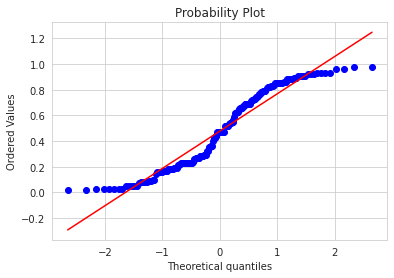

In [15]:
#Test for normality
#Age
#LOS
#Painseverity0to10verbalnumericratingScore_Reported_score
#BodyHeight_cm
#BodyWeight_kg
#DiastolicBloodPressure_mmHg
#Heartrate_permin
#Respiratoryrate_permin
#SystolicBloodPressure_mmHg
#Bodytemperature_Cel
#BodyMassIndex_kgperm2
stats.probplot(sdohdata['SDoH_2020_ZIPCODE_1_0_Risk_Score'], dist="norm",plot=pylab)

In [40]:
#Export to csv
#dataframe.to_csv(r'C:\Users\...\dataframe.csv', index = False)